## Open file and display sorted data

In [1]:
import pandas as pd   #import library for loading data, https://pypi.org/project/pandas/

filename = 'sonificationData'  #name of csv data file

df = pd.read_csv(filename + '.csv')  #load data as a pandas dataframe

df = df.sort_values('artist') #sort data alphabetically
l_data = df.sort_values(by=['monthly_listeners'], ascending=False) #sorting data by monthly listeners descending
l2_data = df.sort_values(by=['monthly_listeners']) #sorting data by monthly listeners ascending
plt_vals = l_data['artist'].values
plt2_vals = l2_data['artist'].values
listeners = l_data["monthly_listeners"]
n_impacts = len(df)

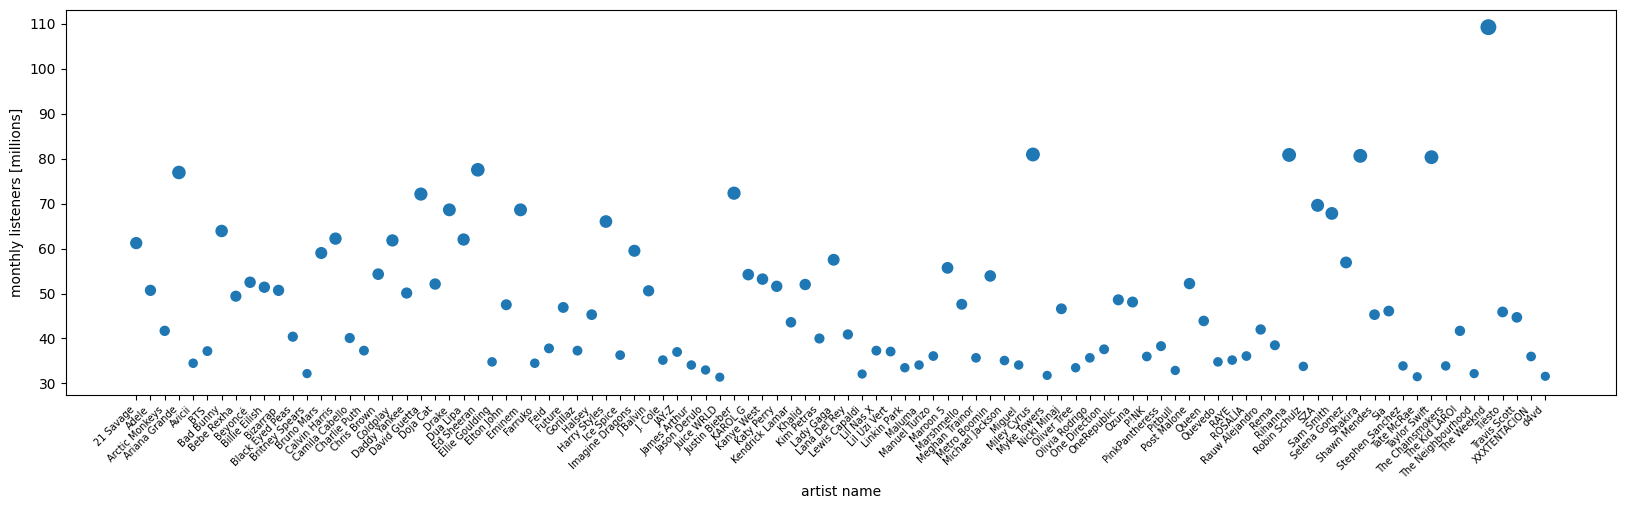

In [2]:
import matplotlib.pylab as plt  #import library for plotting, https://pypi.org/project/matplotlib/

artists = df['artist'].values    #this is a numpy array (not a list), you can do mathematical operations directly on the object
monthly_listeners = df['monthly_listeners'].values 

plt.figure(figsize=(20, 5))
plt.scatter(artists, monthly_listeners, s=monthly_listeners)
plt.xlabel('artist name')
plt.ylabel('monthly listeners [millions]')
plt.xticks(rotation=45, ha='right', fontsize=7)

plt.show()

## Write general mapping function

In [3]:
def map_value(value, min_value, max_value, min_result, max_result):
    '''maps value (or array of values) from one range to another'''
    
    result = min_result + (value - min_value)/(max_value - min_value)*(max_result - min_result)
    return result

In [4]:
from audiolazy import str2midi #import function to convert note names to midi numbers (could also use: midi2str, str2freq, freq2str,freq2midi,midi2freq) https://pypi.org/project/audiolazy/

# 4 octaves of major scale
note_names1 = ['C2','D2','E2','F2','G2','A2','B2',
             'C3','D3','E3','F3','G3','A3','B3',
             'C4','D4','E4','F4','G4','A4','B4',
             'C5','D5','E5','F5','G5','A5','B5']

#4 octaves of major pentatonic scale 
note_names2 = ['C2','D2','E2','G2','A2',
             'C3','D3','E3','G3','A3',
             'C4','D4','E4','G4','A4',
             'C5','D5','E5','G5','A5']

#custom note set (a voicing of a Cmaj13#11 chord, notes from C lydian)
note_names3 = ['C1','C2','G2',
             'C3','E3','G3','A3','B3',
             'D4','E4','G4','A4','B4',
             'D5','E5','G5','A5','B5',
             'D6','E6','F#6','G6','A6']

note_midis = [str2midi(n) for n in note_names3] #make a list of midi note numbers 

n_notes = len(note_midis)
print('Resolution:',n_notes, 'notes')

Resolution: 23 notes


## Map data to MIDI note numbers (map larger numbers to higher notes)

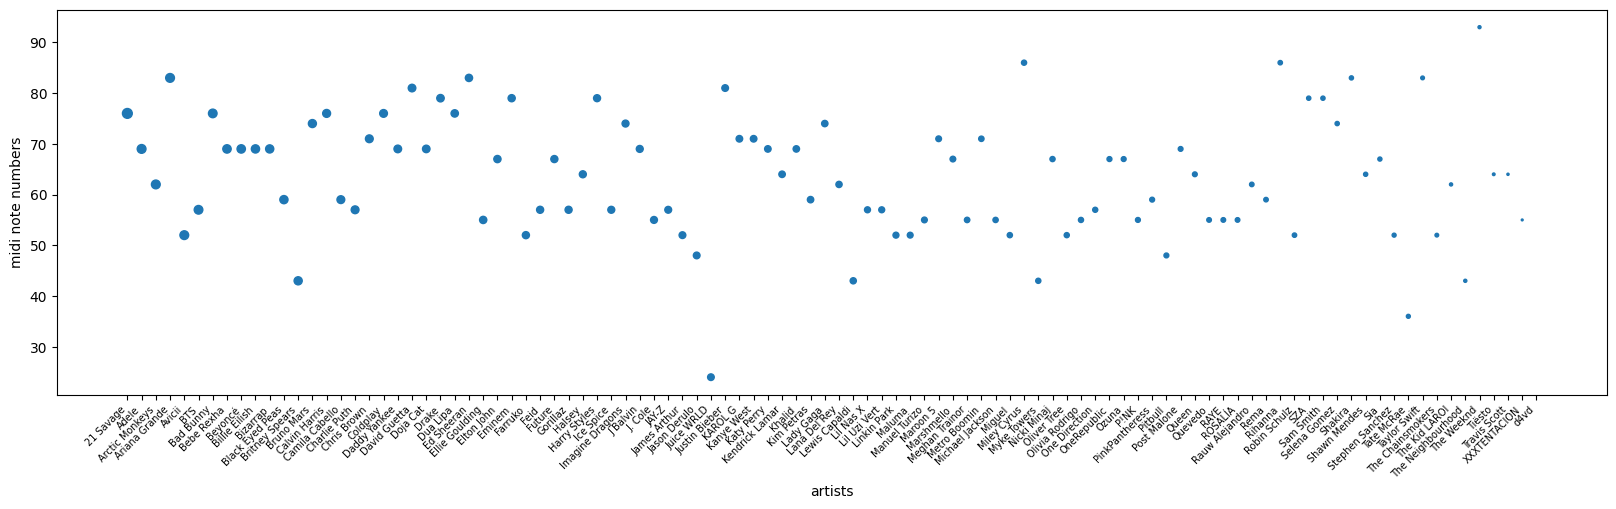

In [5]:
midi_data = []
midi_map = {}
y_data = map_value(listeners,min(listeners),max(listeners),0,1) #normalize data, so it runs from 0 to 1 
y_scale = 0.5  #lower than 1 to spread out more evenly
y_data = y_data**y_scale
for i in range(n_impacts):
    note_index = round(map_value(y_data[i], 1, 0, n_notes-1, 0)) #notice choice of polarity: bigger numbers are mapped to higher notes
    #we round the result because it's a list index which must be an integer
    #print(note_index)
    midi_data.append(note_midis[note_index])
    midi_map[plt_vals[i]] = midi_data[i]

midis = []
for i in range(len(artists)): # assigns midi data to alphabetical artist list
    if artists[i] in midi_map:
        midi = midi_map[artists[i]]
        midis.append(midi)
    
plt.figure(figsize=(20, 5))
plt.scatter(artists, midis, s=50*y_data)
plt.xlabel('artists')
plt.ylabel('midi note numbers')
plt.xticks(rotation=45, ha='right', fontsize=7)
plt.show()
#print(midi_data)
#print(midi_map)
#print(midis)

## Map data to note velocities (map larger craters to greater velocities)
- midi velocity (integer from 0-127) is a combination of volume and intensity (hitting a piano key with a larger velocity makes a louder, more intense sound)
- we are using the same data to control the note pitch and the note velocity (this is called 'dual coding')

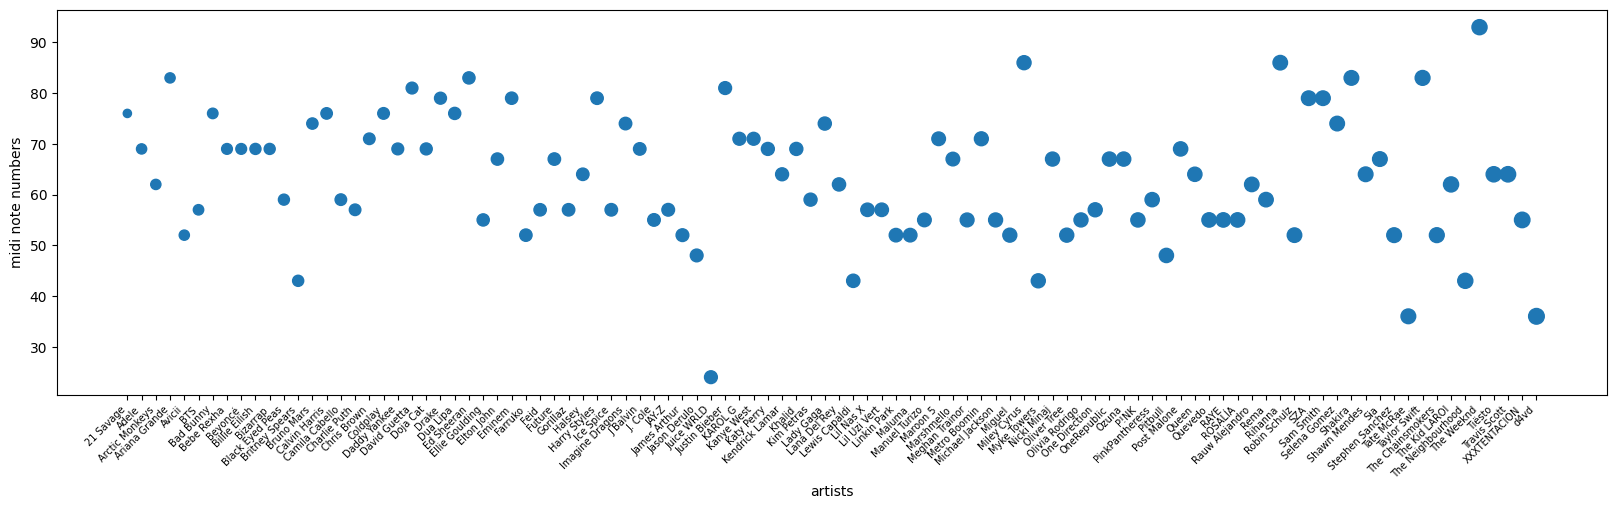

In [6]:
vel_min,vel_max = 35,127   #minimum and maximum note velocity

vel_data = []
vel_map = {}
for i in range(n_impacts):
    note_velocity = round(map_value(y_data[i], 1, 0, vel_min, vel_max)) #bigger craters will be louder
                                                                #we round here because note velocites are integers
    vel_data.append(note_velocity)
    vel_map[plt2_vals[i]] = vel_data[i]
    
vels = []
for i in range(len(artists)): # assigns velocity data to alphabetical artist list
    if artists[i] in vel_map:
        vel = vel_map[artists[i]]
        vels.append(vel)
    
plt.figure(figsize=(20, 5))
plt.scatter(artists, midis, s=vel_data)
plt.xlabel('artists')
plt.ylabel('midi note numbers')
plt.xticks(rotation=45, ha='right', fontsize=7)
plt.show()

## Save data as MIDI file

In [7]:
from midiutil import MIDIFile #import library to make midi file, https://midiutil.readthedocs.io/en/1.2.1/
#create midi file object, add tempo
my_midi_file = MIDIFile(1) #one track 
my_midi_file.addTempo(track=0, time=0, tempo=60) 

#add midi notes
for i in range(n_impacts):
    my_midi_file.addNote(track=0, channel=0, pitch=midis[i], time=i, duration=2, volume=vels[i])

#create and save the midi file itself
with open(filename + '.mid', "wb") as f:
    my_midi_file.writeFile(f) 

## Optional: Listen to MIDI file within jupyter

In [8]:
import pygame #import library for playing midi files, https://pypi.org/project/pygame/

pygame.init()
pygame.mixer.music.load('sonificationData.mp3')
pygame.mixer.music.play()

pygame 2.2.0 (SDL 2.0.22, Python 3.11.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [9]:
pygame.mixer.music.stop()

## Final graph for prototype

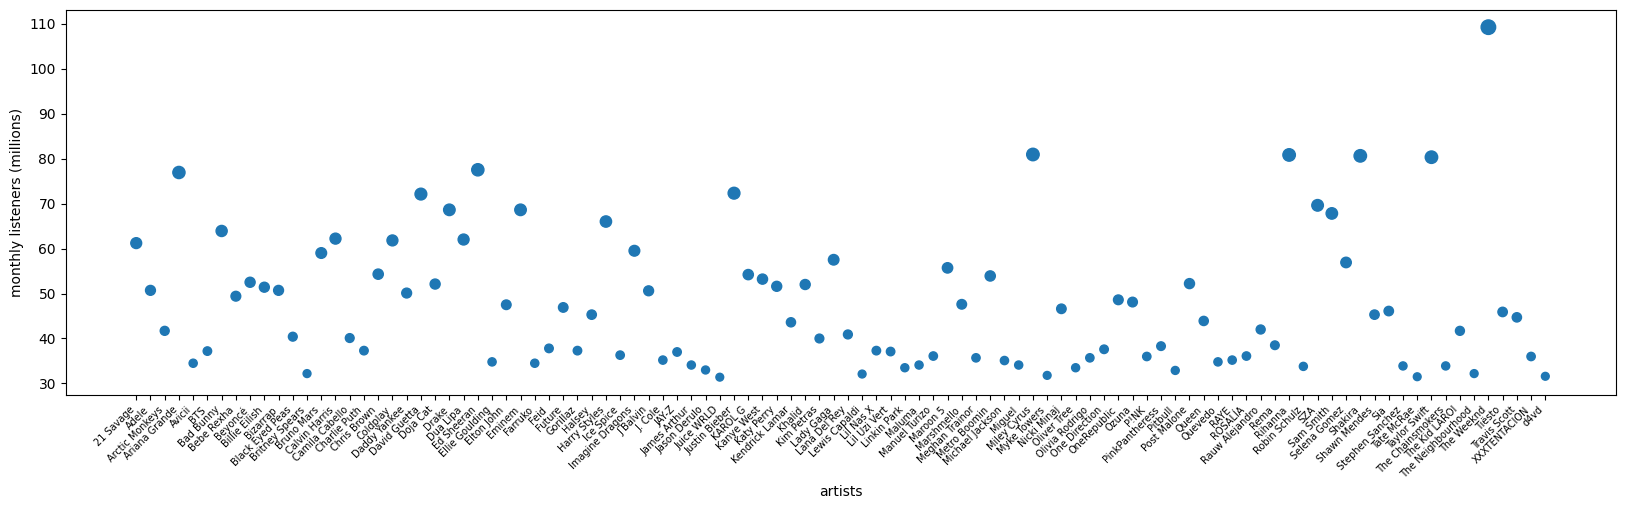

In [11]:
from IPython.display import display, Markdown, clear_output
import ipywidgets as widgets
import pygame
import accessible_output2.outputs.auto
import time

o = accessible_output2.outputs.auto.Auto()
plt.figure(figsize=(20, 5))
plt.scatter(artists, monthly_listeners, s=monthly_listeners)
plt.xlabel('artists')
plt.ylabel('monthly listeners (millions)')
plt.xticks(rotation=45, ha='right', fontsize=7)
plt.show()

btn_start = widgets.Button(description='Sonify Data', layout=widgets.Layout(width='20%', height='50px'), button_style='primary')
btn_stop = widgets.Button(description='Stop Sonification', layout=widgets.Layout(width='20%', height='50px'), button_style='warning')
#speed = widgets.Dropdown(options=[('50%',1),('100%',2),('200%',3)], value=2, tooltip='Change sonification speed')
out = widgets.Output()
graphInfo = "The graph displays 100 artists in alphabetical order and their amount of monthly listeners ranging between 31.4 and 109.2 million listeners"
pygame.init()

def btn_start_click(_):
    global val
    global v_val
    pygame.mixer.music.load('sonificationData.mp3')
    with out:
        # what happens when we press the button
        if v_val==True:
            o.output(graphInfo,interrupt=True)
            time.sleep(len(graphInfo) / 12)
        pygame.mixer.music.play()
        pygame.mixer.music.rewind()
        pygame.mixer.music.set_pos(val)   
        
def btn_stop_click(_):
    with out:
        # what happens when we press the button
        pygame.mixer.music.stop()
        pygame.mixer.music.unload()
        
def volume_slider(x):
    pygame.mixer.music.set_volume(x/100)
    
def section_slider(x):
    global val
    val = x
    if pygame.mixer.music.get_busy():
        pygame.mixer.music.rewind()
        pygame.mixer.music.set_pos(x)
        
def voice_toggle(x):
    global v_val
    v_val = x
    if x == False:
        x=True
    else:
        x=False 

volume = widgets.interactive(volume_slider, 
        x=widgets.IntSlider(value=50,min=0,max=100,step=1,disabled=False,orientation='horizontal',readout=True,readout_format='d', tooltip='Set volume of sonification', layout=widgets.Layout(width='99%')))
section = widgets.interactive(section_slider,
        x=widgets.IntSlider(value=1,min=1,max=100,step=1,disabled=False,orientation='horizontal',readout=True,readout_format='d', tooltip='', layout=widgets.Layout(width='99%')))
voice = widgets.interactive(voice_toggle, x=widgets.Checkbox(value=False,description='Toggle Graph Explanation',disabled=False))

# linking widget and function together using a button's method
btn_start.on_click(btn_start_click)
btn_stop.on_click(btn_stop_click)

box1 = widgets.VBox(children=[voice, widgets.Label('Start from data point:'), section])
box2 = widgets.VBox(children=[widgets.Label('Set volume:'), volume])
box3 = widgets.HBox(children=[btn_start,btn_stop, out])
display(box1)
display(box2)
display(box3)